# Viewing Segmentations

Attempt to view the segmentation mask for qualitative evaluation across the 5 classes 
required for this problem. Locations for each should be specified in a list so that it is 
easily extensible. The function will be specific enough as to specify the location of the 
prediction, and the slice.

Given a folder with raw data, the ground truth segmentations also supply a dictionary of
file locations with other model predictions 

In [29]:
import os 
import subprocess

def setup_data_vars(mine = True, overwrite = True):
    """
    From within any directory related to radiotherapy with backtrack into the data folder
    and execute the data_vars script. The assumption is that the datavars script will
    output the list of environment variables that need to be set. This function will set
    the environment variables for the current session.

    For the mean while, my model hasn't completely finished training, therefore, to get
    this task done, I will use Ben's pretrained nnUNet and then once mine has finished
    training I will use my own. For the mean while, this means that we can choose between
    using Ben's pretrained model or my own.
    """

    # If the environment variables are not set, assume that either a custom one has been
    # provided or resetting them again is a redundant task
    if os.environ.get('nnUNet_raw') is None or overwrite is True:
        # run the script in the data folder for specifying the environment variables
        if mine:
            cwd = os.getcwd().split('/')
            data_dir = os.path.join('/'.join(cwd[:cwd.index('radiotherapy') + 1]), 'data')

            # Assuming the data_vars.sh script echoes the environment variables
            script = os.path.join(data_dir, 'data_vars.sh')
            output = subprocess.run([script], capture_output=True)
            
            assert len(output.stdout) != 0, f"Please check {script} and make sure it echoes \
    the environment variables."

            output = output.stdout.decode('utf-8')
        else:
            data_dir = '/vol/biomedic3/bglocker/nnUNet'

            # Assuming this script won't change, it contains hard coded exports
            script = os.path.join(data_dir, 'exports')

            with open(script, 'r') as file:
                output = file.read()
        
        for line in output.split('\n'):
            if line != '':
                if mine:
                    line = line.split(': ')
                    os.environ[line[0]] = line[1]
                else:
                    line = line.split('=')
                    os.environ[line[0].split(' ')[1]] = line[1]

    assert os.environ.get('nnUNet_raw') is not None, "Environemnt variables not set. \
Please run the data_vars.sh script in the data folder."

In [33]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np
from tqdm import tqdm
import os
import re
import itertools

def plot_segmentations(raw_data_path: str
                       , ground_truth_path: str
                       , slice_default: int
                       , predictions_path: dict
                       , manual_slice: dict = None
                       , subset: set = None
                       ):
    """Generates a grid of each example class and the ground truth with the optional list
    of predictions

    Args:
        raw_data_path (str): path to the raw unlablled CT scans 

        ground_truth_path (str): path to the ground truth segmentations provided by
        clinicians 

        slice_default (int): default slice dimension to take (for now, assume it is the z
        dimension). May throw an error if the z dimension is out of range.

        predictions_path (List[str]): a list of paths that point to a list of predicted
        segmentations that other models have predicted 

        manual_slice (dict, optional): Allows for a manual slice dimension for a certain
        slice, e.g. if the default slice given to others is not descriptive enough.
        Defaults to None.

        subset (set, optional): A subset of the data to display. Defaults to None.
    """

    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>
    # << Before proceeding, check that the arguments are valid >>
    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>

    assert os.path.isdir(raw_data_path),\
          f"{raw_data_path} is not a valid directory for Raw Data"
    assert os.path.isdir(ground_truth_path),\
          f"{ground_truth_path} is not a valid directory for Ground Truth labels"
    for p in predictions_path.values(): assert os.path.isdir(p),\
          f"{p} is not a valid directory for additional Predictions"

    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>
    # << Define the helper plotting functions >>
    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>

    def get_slice_for_image_path(image_path):
        image_id = get_id_from_path(image_path)
        return manual_slice[image_id] if image_id in manual_slice.keys() else slice_default
    
    def get_id_from_path(path, needs_num=True):
        # Assume that it is the full path that points to the file name. The file name
        # should contain a number indicating the id number. It should appear first
        numbers = re.findall('\d+', path.split('/')[-1])
        if needs_num and len(numbers) == 0:
            raise ValueError(f"Could not find a number in {path}")
        if not needs_num and len(numbers) == 0:
            return 0
        return int(numbers[0])

    def plot_base_image(image_path, i, axes, slice):
        # Read image into numpy array
        image = sitk.ReadImage(image_path)
        array_image = sitk.GetArrayFromImage(image)

        # Plot the image into each column
        for j in range(2 + len(predictions_path)):
            axes[i, j].imshow(array_image[:, slice, :], cmap='gray')
    
    def plot_segmentation(seg_path, i, j, slice):
        # Read image into numpy array
        gt_label = sitk.ReadImage(seg_path)
        array_gt_label = sitk.GetArrayFromImage(gt_label)
        
        # Set transparent background for non-segmented areas
        alpha_mask = np.where(array_gt_label[:, slice, :] > 0, 1, 0).astype(np.float32)
        axes[i, j].imshow(array_gt_label[:, slice, :], alpha=alpha_mask, cmap='viridis')

    def format_chart(axes, column_titles, image_paths):
        # Remove ticks and invert y axis
        for i in range(nrows):
            for ax in axes[i,]:
                ax.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False)
                ax.invert_yaxis()

        # Set titles for each column
        for ax, title in zip(axes[0], column_titles):
            ax.set_title(title)

        # Set y labels for each row
        for ax, title in zip(axes[:,0], image_paths):
            id = get_id_from_path(title)
            get_slice_for_image_path(title)
            ax.set_ylabel(f'Sample {id} (Z={slice})')

    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>
    # << Obtain requested image paths >>
    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>

    image_paths = [
        os.path.join(raw_data_path, fn) 
        for fn in sorted(os.listdir(raw_data_path)) 
        if (fn.endswith('.nii.gz')) and (True if subset is None else get_id_from_path(fn) in subset)
    ]
    

    gt_paths = [
        os.path.join(ground_truth_path, fn)
        for fn in sorted(os.listdir(ground_truth_path))
        if (fn.endswith('.nii.gz')) and (True if subset is None else get_id_from_path(fn) in subset)
    ]

    predicted_samples = [
        [
            os.path.join(prediction, fn) 
            for fn in sorted(os.listdir(prediction)) 
            if (fn.endswith('.nii.gz')) and (True if subset is None else get_id_from_path(fn) in subset)
        ] 
        for prediction in predictions_path.values()]

    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>
    # << Plot the data >>
    # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>

    # Define the dimensions of the plot
    ncols = 2 + len(predictions_path)
    nrows = len(subset) if subset != None else len([fn.endswith('.nii.gz') for fn in os.listdir(raw_data_path)])

    _, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 5, nrows * 2.5))

    # For each patient example plot the raw data, ground truth and predictions
    for i, (img, gt, pred) in tqdm(enumerate(itertools.zip_longest(image_paths, gt_paths, [*itertools.zip_longest(*predicted_samples)]))):

        # TODO: change function to display the most problematic z-slice based on a given evaluation metric
        slice = get_slice_for_image_path(img)

        # Plot the base image  
        plot_base_image(img, i, axes, slice)

        # Plot the ground truth segmentation
        plot_segmentation(gt, i, 1, slice)

        # Plot the predictions
        for j, p in enumerate(pred):
            if p is not None:
                plot_segmentation(p, i, j + 2, slice)
            else:
                axes[i, j + 2].cla()

    # Format the axis
    format_chart(axes, column_titles=['Raw Data', 'Ground Truth'] + list(predictions_path.keys()), image_paths=image_paths)        

    # Display summary plots
    organ_class = ground_truth_path.split("/")[-2][11:]
    number = max([0] + [get_id_from_path(fn, False) for fn in os.listdir('reports/') if fn.startswith(f'report{organ_class}')])

    plt.savefig(f'reports/report{organ_class}_{number + 1}.png')
    # plt.show()

2it [00:01,  1.26it/s]


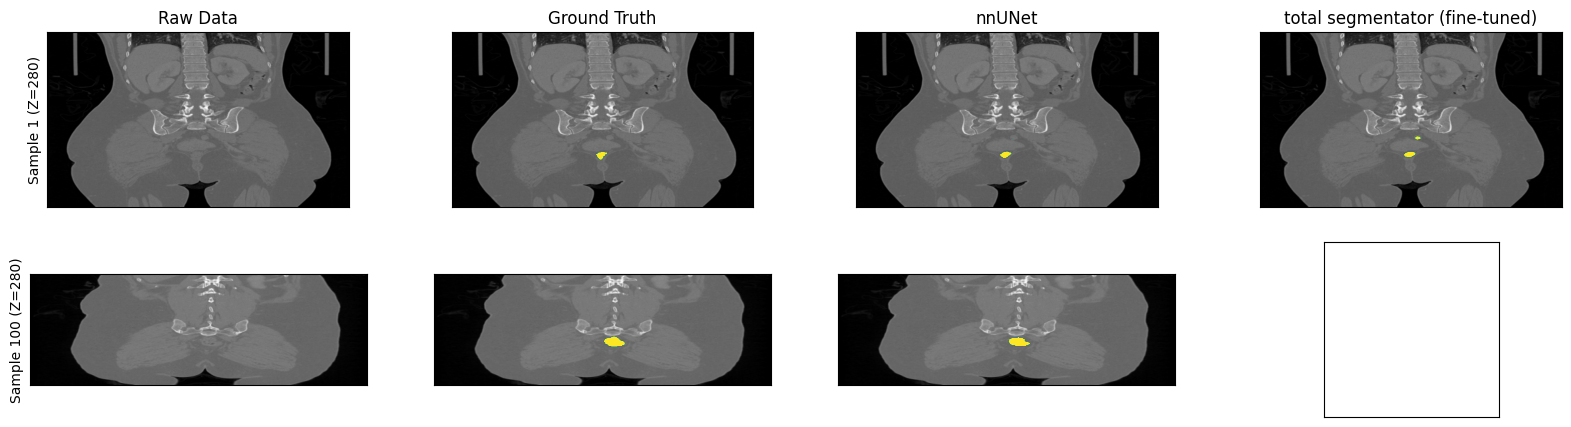

In [34]:
from typing import List


def draw_segmentations(class_id: int, subset: List[int] = None):
    """Prints a plot of the segmentations for the given class in the predefined format.
    This method acts in a factory pattern to generate the plot for each class. 

    Args:
        class_id (int): 1: Anorectum ... 5: Parametrium
    """

    setup_data_vars()

    classes = [os.environ.get('data_Anorectum'), 
            os.environ.get('data_Bladder'), 
            os.environ.get('data_CTVn'), 
            os.environ.get('data_CTVp'), 
            os.environ.get('data_Parametrium'), 
            os.environ.get('data_Uterus'), 
            os.environ.get('data_Vagina')]

    raw_data = [os.path.join(os.environ.get('nnUNet_raw'), x, os.environ.get('data_trainingImages')) for x in classes]
    gt_labels = [os.path.join(os.environ.get('nnUNet_raw'), x, os.environ.get('data_trainingLabels')) for x in classes]

    anorectum = {
        'nnUNet': '/vol/bitbucket/az620/radiotherapy/data/nnUNet_inference/Dataset001_Anorectum/imagesTr_3dhighres',
        'total segmentator (fine-tuned)': '/vol/bitbucket/az620/radiotherapy/data/TotalSegmentator_inference/Dataset001_Anorectum/nnUNetTrainer_50epochs__totseg_nnUNetPlans__3d_fullres',
    }

    bladder = {
        'nnUNet': '/vol/bitbucket/az620/radiotherapy/data/nnUNet_inference/Dataset002_Bladder/imagesTr_3dhighres',
        'total segmentator': '/vol/bitbucket/az620/radiotherapy/data/TotalSegmentator_inference/Dataset002_Bladder/imagesTs'
    }

    ctvn = {
        'nnUNet': '/vol/bitbucket/az620/radiotherapy/data/nnUNet_inference/Dataset003_CTVn/imagesTr_3dhighres',
    }

    ctnp = {
        'nnUNet': '/vol/bitbucket/az620/radiotherapy/data/nnUNet_inference/Dataset004_CTVp/imagesTr_3dhighres',
    }

    parametrium = {
        'nnUNet': '/vol/bitbucket/az620/radiotherapy/data/nnUNet_inference/Dataset005_Parametrium/imagesTr_3dhighres',
    }

    if class_id == 1:
        plot_segmentations(raw_data_path=raw_data[0]
                           , ground_truth_path=gt_labels[0]
                           , slice_default=300
                           , predictions_path=anorectum
                           , manual_slice={4: 280,
                                           6: 290,
                                           100: 280}
                           , subset=subset)
    elif class_id == 2:
        plot_segmentations(raw_data_path=raw_data[1]
                           , ground_truth_path=gt_labels[1]
                           , slice_default=240
                           , predictions_path=bladder
                           , manual_slice={}
                           , subset=subset)
    elif class_id == 3:
        plot_segmentations(raw_data_path=raw_data[2]
                           , ground_truth_path=gt_labels[2]
                           , slice_default=250
                           , predictions_path=ctvn
                           , manual_slice={}
                           , subset=subset)
    elif class_id == 4:
        plot_segmentations(raw_data_path=raw_data[3]
                           , ground_truth_path=gt_labels[3]
                           , slice_default=275
                           , predictions_path=ctnp
                           , manual_slice={}
                           , subset=subset)
    elif class_id == 5:
        plot_segmentations(raw_data_path=raw_data[4]
                           , ground_truth_path=gt_labels[4] 
                           , slice_default=265 
                           , predictions_path=parametrium
                           , manual_slice={}
                           , subset=subset)
    else:
        raise ValueError("Invalid class_id. Please choose a class between 1 and 5.")
    
# draw_segmentations(class_id=2) #,  subset=[1,2,3,4,5,6,7])
# draw_segmentations(class_id=5,  subset=[1,2]) #,3,4,5,6,7])

# for i in range(1, 6):
#     draw_segmentations(class_id=i)

draw_segmentations(class_id=1, subset=[1, 100])